In [1]:
#-- DEPENDENCIES 

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.patches import Rectangle
import pandas as pd
import os
import numpy as np

import pyreproj

import sys

# Add the path of the pyTMD-master directory to sys.path
# This should be the directory containing the __init__.py file and the module directories
#pytmd_master_path = r'directory\NISAR Notebook Development Plan for Vertical Displacement\pyTMD\pyTMD-master'

# Append the path to sys.path if it's not already included
#if pytmd_master_path not in sys.path:
#    sys.path.append(pytmd_master_path)
    
#%matplotlib inline

import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# import ipywidgets as widgets
# from IPython.display import HTML

#from pyTMD.calc_delta_time import calc_delta_time
#from pyTMD.read_tide_model import extract_tidal_constants
#from pyTMD.read_netcdf_model import extract_netcdf_constants
#from pyTMD.read_GOT_model import extract_GOT_constants
#from pyTMD.infer_minor_corrections import infer_minor_corrections
#from pyTMD.predict_tide import predict_tide

import pyTMD

# import folium

# Set the input coordinates to be fixed or change with GLs
ONLY_FIXED = True
fixed_points = [(-66.3293,98.3938)]

ModuleNotFoundError: No module named 'pyTMD.calc_delta_time'

/tmp/ipykernel_3854/797682667.py:35: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  ax=flowLine.plot(axes=ax)
/tmp/ipykernel_3854/797682667.py:36: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  refGL.plot(axes=ax)


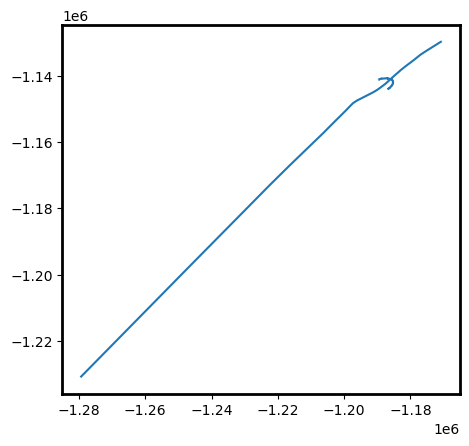

In [2]:
#   CALCULATE GROUNDING LINE RETREAT 

#****************************************************************************
#   DEFINE ON USER SPECIFIC PATHS
#********************************

#-- Define folders
dataFolder = 'GroundingLineShapefile/DenmanGlacier/'
flowLineFolder = 'ReferencePoint/'
#-- Define files
flowLine_name = 'flowline.shp'
refGL_name = 'reference.shp'

#****************************************************************************
# Rest of block is generalized
#*********************


directory = os.fsencode(dataFolder)
data=[]
for dataFile in os.listdir(directory):
     filename = os.fsdecode(dataFile)
     if filename.endswith('.shp'): 
         data.append(filename)
         continue
     else:
         continue
            
# Read in flowline and reference GL data
# *** flowline data will loop in the future
flowLine = gpd.read_file(flowLineFolder+flowLine_name)
refGL = gpd.read_file(flowLineFolder+refGL_name)
# refGL = gpd.read_file(dataFolder+data[4])
f,ax=plt.subplots(1)
ax=flowLine.plot(axes=ax)
refGL.plot(axes=ax)
plt.show()


In [3]:
points = []
df_GL = pd.DataFrame(columns=['Name', 'x', 'y', 'Distance', 'Datetime 1', 'Datetime 2', 'Datetime 3', 'Datetime 4', 'Reference'])

for i in range(len(data) + 1):
    if i == 0:
        print('Loading reference grounding line file')
        p0 = flowLine.intersection(refGL)
        points.append(p0)
        
        name = 'p%s' % i
        GLdata = {'Name': name, 'x': p0.x[0], 'y': p0.y[0], 'Distance': p0.distance(p0)[0], 'Datetime 1': np.nan, 'Datetime 2': np.nan, 'Datetime 3': np.nan, 'Datetime 4': np.nan, 'Reference': refGL_name}
        df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)
    else:
        print('Loading data file:')
        print('     ', data[i-1])
        
        GL = gpd.read_file(dataFolder + data[i-1])
        year1 = int('20' + data[i-1][7:9]); month1 = int(data[i-1][9:11]); day1 = int(data[i-1][11:13])
        hr1 = int(data[i-1][-18:-16]); mins1 = int(data[i-1][-16:-14]); secs1 = int(data[i-1][-14:-12])
        date1 = datetime.datetime(year1, month1, day1, hr1, mins1, secs1)

        year2 = int('20' + data[i-1][14:16]); month2 = int(data[i-1][16:18]); day2 = int(data[i-1][18:20])
        date2 = datetime.datetime(year2, month2, day2, hr1, mins1, secs1)

        year3 = int('20' + data[i-1][21:23]); month3 = int(data[i-1][23:25]); day3 = int(data[i-1][25:27])
        hr3 = int(data[i-1][-10:-8]); mins3 = int(data[i-1][-8:-6]); secs3 = int(data[i-1][-6:-4])
        date3 = datetime.datetime(year3, month3, day3, hr3, mins3, secs3)

        year4 = int('20' + data[i-1][28:30]); month4 = int(data[i-1][30:32]); day4 = int(data[i-1][32:34])
        date4 = datetime.datetime(year4, month4, day4, hr3, mins3, secs3)
        
        print('      index: ', i)
        print('      # of GL segments: ', len(GL))
        temp = []
        for j in range(len(GL)):
            if GL['geometry'][j] is not None:
                point = flowLine.intersection(GL['geometry'][j])
                if point.is_empty[0] == False:
                    temp.append(point)
                    points.append(point)
                    print('     ', point[0])
        
        if len(GL) == 0:
            points.append(np.nan)
            name = 'no GL data'
            GLdata = {'Name': name, 'x': np.nan, 'y': np.nan, 'Distance': np.nan, 'Datetime 1': date1, 'Datetime 2': date2, 'Datetime 3': date3, 'Datetime 4': date4, 'Reference': data[i-1]}
            df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)           
        elif len(temp) == 0:
            print('      no intersect')
            name = 'no intersect'
            points.append(np.nan)
            GLdata = {'Name': name, 'x': np.nan, 'y': np.nan, 'Distance': np.nan, 'Datetime 1': date1, 'Datetime 2': date2, 'Datetime 3': date3, 'Datetime 4': date4, 'Reference': data[i-1]}
            df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)
        else: 
            name = 'p%s' % i
            GLdata = {'Name': name, 'x': points[i].x[0], 'y': points[i].y[0], 'Distance': p0.distance(points[i])[0], 'Datetime 1': date1, 'Datetime 2': date2, 'Datetime 3': date3, 'Datetime 4': date4, 'Reference': data[i-1]}
            df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)

# Now df_GL contains all the data
print(df_GL)

Loading reference grounding line file
Loading data file:
      gl_157_201010_201024_201024_201107_34475-34682-34682-34889_T192907_T192907.shp
      index:  1
      # of GL segments:  0
         Name             x             y  Distance          Datetime 1  \
0          p0 -1.185973e+06 -1.141030e+06       0.0                 NaT   
1  no GL data           NaN           NaN       NaN 2020-10-10 19:29:07   

           Datetime 2          Datetime 3          Datetime 4  \
0                 NaT                 NaT                 NaT   
1 2020-10-24 19:29:07 2020-10-24 19:29:07 2020-11-07 19:29:07   

                                           Reference  
0                                      reference.shp  
1  gl_157_201010_201024_201024_201107_34475-34682...  


/tmp/ipykernel_3854/2181183454.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)
/tmp/ipykernel_3854/2181183454.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_GL = pd.concat([df_GL, pd.DataFrame(GLdata, index=[0])], ignore_index=True)


In [4]:
# calculate lat, long
# all means apply all shape files to this point
tasks = {}
for fixed_point in fixed_points:
    tasks[fixed_point] = 'all'

if not ONLY_FIXED:
    rp = pyreproj.Reprojector()
    transform = rp.get_transformation_function(from_srs=3031, to_srs='epsg:4326')
    for index, row in df_GL.iterrows():
        result = transform(row['x'], row['y'])
        tasks[tuple(result)] = row['Reference']

In [9]:
#   CALCULATE TIDES

#   MODIFY BASED ON MODEL, GLACIER, AND USER SPECIFIC PATHS
#****************************************************************************
#-- Directory with tide models
tide_dir = 'pyTMD/pyTMD-master'

#-- Artic model info
#MODEL = 'AOTIM-5'
#grid_file = os.path.join(tide_dir,'aotim5_tmd','grid_Arc5km')
#model_file = os.path.join(tide_dir,'aotim5_tmd','h_Arc5km.oce')
#reference = ('https://www.esr.org/research/polar-tide-models/list-of-polar-tide-models/aotim-5/')
#model_format = 'OTIS'
#EPSG = 'PSNorth'
#TYPE = 'z'

# #-- Antarctica model info
MODEL = 'CATS2008'
grid_file = os.path.join(tide_dir,'CATS2008','grid_CATS2008')
#model_file = os.path.join(tide_dir,'CATS2008','hf.CATS2008.out')
model_format = 'OTIS'
EPSG = 'CATS2008'
TYPE = 'z'

#-- Glacier specific


#****************************************************************************
# Rest of block is generalized
#*********************


#************************************************************************************************
#-- Calculating tides
#*********************

df_tides = list()
df_GL_nan = pd.isna(df_GL.iloc[:]['x'])

for point, shape_file in tasks.items():
    # Handle NaN values for latitude and longitude
    if pd.isna(point[0]) or pd.isna(point[1]):
        # Skip or use default values for lat, long
        # Example: lat, long = default_lat, default_long
        continue
    else:
        lat, long = point
    #-- Parameters to save for analysis
    df_tide = pd.DataFrame(columns=['Timestamp Series Month', 'Tide Timeseries Month', 
                                'Datetime 1', 'Timestamp Series 1', 'Tide 1', 'dh/dt 1', 'Tide Timeseries 1', 
                                'Datetime 2', 'Timestamp Series 2', 'Tide 2', 'dh/dt 2', 'Tide Timeseries 2', 
                                'Datetime 3', 'Timestamp Series 3', 'Tide 3', 'dh/dt 3', 'Tide Timeseries 3', 
                                'Datetime 4', 'Timestamp Series 4', 'Tide 4', 'dh/dt 4', 'Tide Timeseries 4', 
                                'Reference'])
    for i in range(len(data)):
        #if df_GL_nan[i + 1]: continue
        if shape_file != 'all' \
           and df_GL.iloc[i+1]['Reference'] != shape_file:
            continue
       
        YMD = []
        print(data[i])
        YMD = [df_GL.iloc[i+1]['Datetime 1'], df_GL.iloc[i+1]['Datetime 2'], df_GL.iloc[i+1]['Datetime 3'], df_GL.iloc[i+1]['Datetime 4']]

        #-- Calculate hourly tides for full month
        print('Calculating hourly tides for full month')
        # Convert dates
        tide_time_month = 367.0*YMD[0].year - \
            np.floor(7.0*(YMD[0].year + np.floor((YMD[0].month+9.0)/12.0))/4.0) - \
            np.floor(3.0*(np.floor((YMD[0].year + (YMD[0].month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
            np.floor(275.*YMD[0].month/9.0) + YMD[0].day - 7.0 + np.arange(24.0*31.0)/24.0 - 727594.0
        # Convert timestamp series back into something inutitive
        ref_date = YMD[0] - datetime.timedelta(days=7, hours=YMD[0].hour, minutes=YMD[0].minute, seconds=YMD[0].second)
        monthDates = [ref_date + datetime.timedelta(hours=x) for x in range(24*31)]

        # Calculating tides
        #-- read tidal constants and interpolate to grid points
        # model_format in ('OTIS','ATLAS'):
        amp,ph,D,c = pyTMD.io.extract_constants(np.array([long]), np.array([lat]), grid_file, model_file, EPSG, TYPE, METHOD='spline', GRID=model_format)
        DELTAT = np.zeros_like(tide_time_month)

        #-- calculate complex phase in radians for Euler's
        cph = -1j*ph*np.pi/180.0
        #-- calculate constituent oscillation
        hc = amp*np.exp(cph) 
        tide_timeSeries = []
        for hour in range(len(tide_time_month)):
            TIDE = pyTMD.predict_tide(tide_time_month[hour], hc, c, DELTAT=DELTAT[hour],
                CORRECTIONS=model_format)
            MINOR = pyTMD.infer_minor_corrections(tide_time_month[hour], hc, c,
                DELTAT=DELTAT[hour], CORRECTIONS=model_format)
            #-- add major and minor components and reform grid
            #-- convert from meters to centimeters
            tide_timeSeries.append(100.0*(TIDE+MINOR).data[0])
        print('Completed')

        #-- Calculate daily tides every quarter hour for each aquisition day
        # Convert dates
        tide_time_day1 = 367.0*YMD[0].year - \
            np.floor(7.0*(YMD[0].year + np.floor((YMD[0].month+9.0)/12.0))/4.0) - \
            np.floor(3.0*(np.floor((YMD[0].year + (YMD[0].month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
            np.floor(275.*YMD[0].month/9.0) + YMD[0].day + YMD[0].hour/24 -0.5 + np.arange(97)/96.0 - 727594.0
        tide_time_day2 = 367.0*YMD[1].year - \
            np.floor(7.0*(YMD[1].year + np.floor((YMD[1].month+9.0)/12.0))/4.0) - \
            np.floor(3.0*(np.floor((YMD[1].year + (YMD[1].month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
            np.floor(275.*YMD[1].month/9.0) + YMD[1].day + YMD[1].hour/24 -0.5 + np.arange(97)/96.0 - 727594.0
        tide_time_day3 = 367.0*YMD[2].year - \
            np.floor(7.0*(YMD[2].year + np.floor((YMD[2].month+9.0)/12.0))/4.0) - \
            np.floor(3.0*(np.floor((YMD[2].year + (YMD[2].month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
            np.floor(275.*YMD[2].month/9.0) + YMD[2].day + YMD[2].hour/24 -0.5 + np.arange(97)/96.0 - 727594.0
        tide_time_day4 = 367.0*YMD[3].year - \
            np.floor(7.0*(YMD[3].year + np.floor((YMD[3].month+9.0)/12.0))/4.0) - \
            np.floor(3.0*(np.floor((YMD[3].year + (YMD[3].month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
            np.floor(275.*YMD[3].month/9.0) + YMD[3].day + YMD[3].hour/24 -0.5 + np.arange(97)/96.0 - 727594.0

        # Convert timestamp series back into something inutitive
        ref_day1 = YMD[0] - datetime.timedelta(hours=12, minutes=YMD[0].minute, seconds=YMD[0].second)
        timeDay1 = [ref_day1 + datetime.timedelta(minutes=x) for x in range(0, 1455, 15)]
        ref_day2 = YMD[1] - datetime.timedelta(hours=12, minutes=YMD[1].minute, seconds=YMD[1].second)
        timeDay2 = [ref_day2 + datetime.timedelta(minutes=x) for x in range(0, 1455, 15)]
        ref_day3 = YMD[2] - datetime.timedelta(hours=12, minutes=YMD[2].minute, seconds=YMD[2].second)
        timeDay3 = [ref_day3 + datetime.timedelta(minutes=x) for x in range(0, 1455, 15)]
        ref_day4 = YMD[3] - datetime.timedelta(hours=12, minutes=YMD[3].minute, seconds=YMD[3].second)
        timeDay4 = [ref_day4 + datetime.timedelta(minutes=x) for x in range(0, 1455, 15)]


        # Calculating tides
        print('Calculating tides at every quarter hour for aquisition days')
        # Date 1 
        #-- read tidal constants and interpolate to grid points
        amp,ph,D,c = pyTMD.extract_tidal_constants(np.array([long]), np.array([lat]), grid_file, model_file, EPSG, TYPE, METHOD='spline', GRID=model_format)
        DELTAT = np.zeros_like(tide_time_day1)
        #-- calculate complex phase in radians for Euler's
        cph = -1j*ph*np.pi/180.0
        #-- calculate constituent oscillation
        hc = amp*np.exp(cph) 
        tide_timeSeries_day1 = []
        for mins15 in range(len(tide_time_day1)):
            #-- predict tidal elevations at time and infer minor corrections
            TIDE = pyTMD.predict_tide(tide_time_day1[mins15], hc, c, DELTAT=DELTAT[mins15],
                CORRECTIONS=model_format)
            MINOR = pyTMD.infer_minor_corrections(tide_time_day1[mins15], hc, c,
                DELTAT=DELTAT[mins15], CORRECTIONS=model_format)
            #-- add major and minor components and reform grid
            #-- convert from meters to centimeters
            tide_timeSeries_day1.append(100.0*(TIDE+MINOR).data[0])
        # Index for tide height approximation
        tide1 = 0
        for j in range(len(timeDay1)):
            x = timeDay1[j]
            if (x.hour == YMD[0].hour) & (np.abs(x.minute - YMD[0].minute) < 8):
                tide1 = tide_timeSeries_day1[j]
                dh_dt1 = ((tide_timeSeries_day1[j]-tide_timeSeries_day1[j-1])/15.0)*60.0 
            elif (tide1 == 0) & (x.hour - YMD[0].hour == 1):
                tide1 = tide_timeSeries_day1[j]
                dh_dt1 = ((tide_timeSeries_day1[j]-tide_timeSeries_day1[j-1])/15.0)*60.0 
        print('     Date 1 finished')

        # Date 2 
        #-- read tidal constants and interpolate to grid points
        amp,ph,D,c = pyTMD.extract_tidal_constants(np.array([long]), np.array([lat]), grid_file, model_file, EPSG, TYPE, METHOD='spline', GRID=model_format)
        DELTAT = np.zeros_like(tide_time_day2)
        #-- calculate complex phase in radians for Euler's
        cph = -1j*ph*np.pi/180.0
        #-- calculate constituent oscillation
        hc = amp*np.exp(cph) 
        tide_timeSeries_day2 = []
        for mins15 in range(len(tide_time_day2)):
            #-- predict tidal elevations at time and infer minor corrections
            TIDE = pyTMD.predict_tide(tide_time_day2[mins15], hc, c, DELTAT=DELTAT[mins15],
                CORRECTIONS=model_format)
            MINOR = pyTMD.infer_minor_corrections(tide_time_day2[mins15], hc, c,
                DELTAT=DELTAT[mins15], CORRECTIONS=model_format)
            #-- add major and minor components and reform grid
            #-- convert from meters to centimeters
            tide_timeSeries_day2.append(100.0*(TIDE+MINOR).data[0])
        tide2 = 0
        for j in range(len(timeDay2)):
            x = timeDay2[j]
            if (x.hour == YMD[1].hour) & (np.abs(x.minute - YMD[1].minute) < 8):
                tide2 = tide_timeSeries_day2[j]
                dh_dt2 = ((tide_timeSeries_day2[j]-tide_timeSeries_day2[j-1])/15.0)*60.0
            elif (tide2 == 0) & (x.hour - YMD[1].hour == 1):
                tide2 = tide_timeSeries_day2[j]
                dh_dt2 = ((tide_timeSeries_day2[j]-tide_timeSeries_day2[j-1])/15.0)*60.0 
        print('     Date 2 finished')

        # Date 3 
        #-- read tidal constants and interpolate to grid points
        amp,ph,D,c = pyTMD.extract_tidal_constants(np.array([long]), np.array([lat]), grid_file, model_file, EPSG, TYPE, METHOD='spline', GRID=model_format)
        DELTAT = np.zeros_like(tide_time_day3)
        #-- calculate complex phase in radians for Euler's
        cph = -1j*ph*np.pi/180.0
        #-- calculate constituent oscillation
        hc = amp*np.exp(cph) 
        tide_timeSeries_day3 = []
        for mins15 in range(len(tide_time_day3)):
            #-- predict tidal elevations at time and infer minor corrections
            TIDE = pyTMD.predict_tide(tide_time_day3[mins15], hc, c, DELTAT=DELTAT[mins15],
                CORRECTIONS=model_format)
            MINOR = pyTMD.infer_minor_corrections(tide_time_day3[mins15], hc, c,
                DELTAT=DELTAT[mins15], CORRECTIONS=model_format)
            #-- add major and minor components and reform grid
            #-- convert from meters to centimeters
            tide_timeSeries_day3.append(100.0*(TIDE+MINOR).data[0])
        tide3 = 0
        for j in range(len(timeDay3)):
            x = timeDay3[j]
            if (x.hour == YMD[2].hour) & (np.abs(x.minute - YMD[2].minute) < 8):
                tide3 = tide_timeSeries_day3[j]
                dh_dt3 = ((tide_timeSeries_day3[j]-tide_timeSeries_day3[j-1])/15.0)*60.0 
            elif (tide3 == 0) & (x.hour - YMD[2].hour == 1):
                tide3 = tide_timeSeries_day3[j]
                dh_dt3 = ((tide_timeSeries_day3[j]-tide_timeSeries_day3[j-1])/15.0)*60.0 
        print('     Date 3 finished')

        # Date 4 
        #-- read tidal constants and interpolate to grid points
        amp,ph,D,c = pyTMD.extract_tidal_constants(np.array([long]), np.array([lat]), grid_file, model_file, EPSG, TYPE, METHOD='spline', GRID=model_format)
        DELTAT = np.zeros_like(tide_time_day4)
        #-- calculate complex phase in radians for Euler's
        cph = -1j*ph*np.pi/180.0
        #-- calculate constituent oscillation
        hc = amp*np.exp(cph) 
        tide_timeSeries_day4 = []
        for mins15 in range(len(tide_time_day4)):
            #-- predict tidal elevations at time and infer minor corrections
            TIDE = pyTMD.predict_tide(tide_time_day4[mins15], hc, c, DELTAT=DELTAT[mins15],
                CORRECTIONS=model_format)
            MINOR = pyTMD.infer_minor_corrections(tide_time_day4[mins15], hc, c,
                DELTAT=DELTAT[mins15], CORRECTIONS=model_format)
            #-- add major and minor components and reform grid
            #-- convert from meters to centimeters
            tide_timeSeries_day4.append(100.0*(TIDE+MINOR).data[0])
        tide4 = 0
        for j in range(len(timeDay4)):
            x = timeDay4[j]
            if (x.hour == YMD[3].hour) & (np.abs(x.minute - YMD[3].minute) < 8):
                tide4 = tide_timeSeries_day4[j]
                dh_dt4 = ((tide_timeSeries_day4[j]-tide_timeSeries_day4[j-1])/15.0)*60.0 
            elif (tide4 == 0) & (x.hour - YMD[3].hour == 1):
                tide4 = tide_timeSeries_day4[j]
                dh_dt4 = ((tide_timeSeries_day4[j]-tide_timeSeries_day4[j-1])/15.0)*60.0 
        print('     Date 4 finished')

        tide_DATA = {'Timestamp Series Month':monthDates , 'Tide Timeseries Month':tide_timeSeries,
                     'Datetime 1':df_GL.iloc[i+1]['Datetime 1'], 'Timestamp Series 1':timeDay1, 'Tide 1':tide1, 'dh/dt 1':dh_dt1, 'Tide Timeseries 1':tide_timeSeries_day1, 
                     'Datetime 2':df_GL.iloc[i+1]['Datetime 2'], 'Timestamp Series 2':timeDay2, 'Tide 2':tide2, 'dh/dt 2':dh_dt2, 'Tide Timeseries 2':tide_timeSeries_day2, 
                     'Datetime 3':df_GL.iloc[i+1]['Datetime 3'], 'Timestamp Series 3':timeDay3, 'Tide 3':tide3, 'dh/dt 3':dh_dt3, 'Tide Timeseries 3':tide_timeSeries_day3, 
                     'Datetime 4':df_GL.iloc[i+1]['Datetime 4'], 'Timestamp Series 4':timeDay4, 'Tide 4':tide4, 'dh/dt 4':dh_dt4, 'Tide Timeseries 4':tide_timeSeries_day4, 
                     'Reference':data[i]}
        df_tide = df_tide.append(tide_DATA, ignore_index=True)
        print('Saving data')
        print(data[i], shape_file)
    if len(df_tide) != 0:
        df_tides.append(df_tide)

print('Tide calculations complete')

gl_157_201010_201024_201024_201107_34475-34682-34682-34889_T192907_T192907.shp
Calculating hourly tides for full month


ValueError: cannot reshape array of size 67384788 into shape (1832001568,2)

In [7]:
#If you use fixed point, please keep df_tide_i = 0, select the GL by changing j; 
#If you use unfixed points, please keep j = 0, and select the GL by changing df_tide_i
j = 0
df_tide_i = 0
df_tide = df_tides[df_tide_i]

#-- Set index for tide data plot
#****************************************************************************

IndexError: list index out of range

In [10]:
DifferentialTideWithoutIBE = abs((tide1-tide2)-(tide3-tide4))
print(DifferentialTideWithoutIBE)

NameError: name 'tide1' is not defined

In [20]:
#   COMPUTE IBE

import netCDF4 as nc
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

netcdf_file_path = "MeanSeaLevelPressure/MSLP.nc"  # Replace with the actual file path
fixed_point = (-66.3293,98.3938)  # Replace with actual latitude and longitude

# Open the NetCDF file
dataset = nc.Dataset(netcdf_file_path)

# Read variables
time_var = dataset.variables['time']
value_var = dataset.variables['msl']

# Read latitude and longitude data
latitudes = dataset.variables['latitude'][:]  # Replace 'latitude' with the actual variable name in your file
longitudes = dataset.variables['longitude'][:]  # Replace 'longitude' with the actual variable name in your file

# Function to find the nearest index for a given latitude and longitude
def find_nearest_index(point, latitudes, longitudes):
    # Calculate the absolute difference
    lat_diff = np.abs(latitudes - point[0])
    lon_diff = np.abs(longitudes - point[1])

    # Find the index of the nearest latitude and longitude
    lat_idx = np.argmin(lat_diff)
    lon_idx = np.argmin(lon_diff)

    return lat_idx, lon_idx

lat_idx, lon_idx = find_nearest_index(fixed_point, latitudes, longitudes)

# Read data for the fixed point
times = time_var[:]
values = value_var[:, lat_idx, lon_idx]

def convert_time(time_val):
    reference_date = datetime(1900, 1, 1)  # Reference date
    return reference_date + timedelta(hours=int(time_val))  # Convert hours to timedelta

# Convert NETCDF_DIM_time to datetime
converted_times = [convert_time(t) for t in times]

# Extract years from the datetime objects
years = [t.year for t in converted_times]

# Group data by year and calculate the mean for each year
unique_years = set(years)
yearly_means = {year: np.mean(values[np.array(years) == year]) for year in unique_years}

# Assign the mean value of the corresponding year to each time point
mean_values = [yearly_means[year] for year in years]
ibe_values = [1/(980*1.028)*1000*(mean_val/100 - val/100) for mean_val, val in zip(mean_values, values)]

# Create a DataFrame and save to Excel
df = pd.DataFrame({
    'Time': converted_times,
    'IBE': ibe_values,
    'Mean': mean_values,
    'value': values
})
excel_file_path = "MeanSeaLevelPressure/MSLP_excel.xlsx"  # Replace with actual output path
df.to_excel(excel_file_path, index=False)

In [16]:
#   ADD IBE TO TIDE MODEL RESULTS

excel_file_path = "MeanSeaLevelPressure/MSLP_excel.xlsx"
import pandas as pd

df = pd.read_excel(excel_file_path, sheet_name="Sheet1") # can also index sheet by name or fetch all sheets
dates_excel = df['Time'].tolist()
ibe_excel = df['IBE'].tolist()

dates_start = []
dates_end = []
for i in dates_excel:
    # create a list whose elements are [startTime, endTime)
    start = i - pd.DateOffset(hours = 0.51)
    end = i + pd.DateOffset(hours = 0.49)
    dates_start.append(start)
    dates_end.append(end)
date_range = [dates_start, dates_end]

for i in range(4):
    timeDay = df_tide.iloc[j][f"Timestamp Series {i + 1}"]
    tideDay = df_tide.iloc[j][f"Tide Timeseries {i + 1}"]
    target_ibes = []
    for ii, one_time in enumerate(timeDay):
        target_ibe = None
        for iii in range(len(dates_start)):
            if dates_start[iii] <= one_time < dates_end[iii]:
                target_ibe = ibe_excel[iii]
                break
        if target_ibe is None:
            print(f"No match found for time {one_time}")  # Debugging print statement
        target_ibes.append(target_ibe)
    
    # add tideDay and target_ibes
    for ii in range(len(df_tide.iloc[j][f"Tide Timeseries {i + 1}"])):
        if target_ibes[ii] is not None:
            df_tide.iloc[j][f"Tide Timeseries {i + 1}"][ii] += target_ibes[ii]

    
    day_point = df_tide.iloc[j][f'Datetime {i + 1}']
    target_ibe = None
    for iii in range(len(dates_start)):
        if dates_start[iii] <= day_point < dates_end[iii]:
            target_ibe = ibe_excel[iii]
            break
    assert target_ibe is not None
    df_tide.iloc[j][f'Tide {i + 1}'] += target_ibe
    df_tide.at[j, f"Tide {i+1}"] = df_tide.iloc[j][f'Tide {i + 1}'] +target_ibe

IndexError: single positional indexer is out-of-bounds

GL data file displayed:  gl_157_181128_181210_181210_181222_34475-34682-34682-34889_T192907_T192907.shp


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


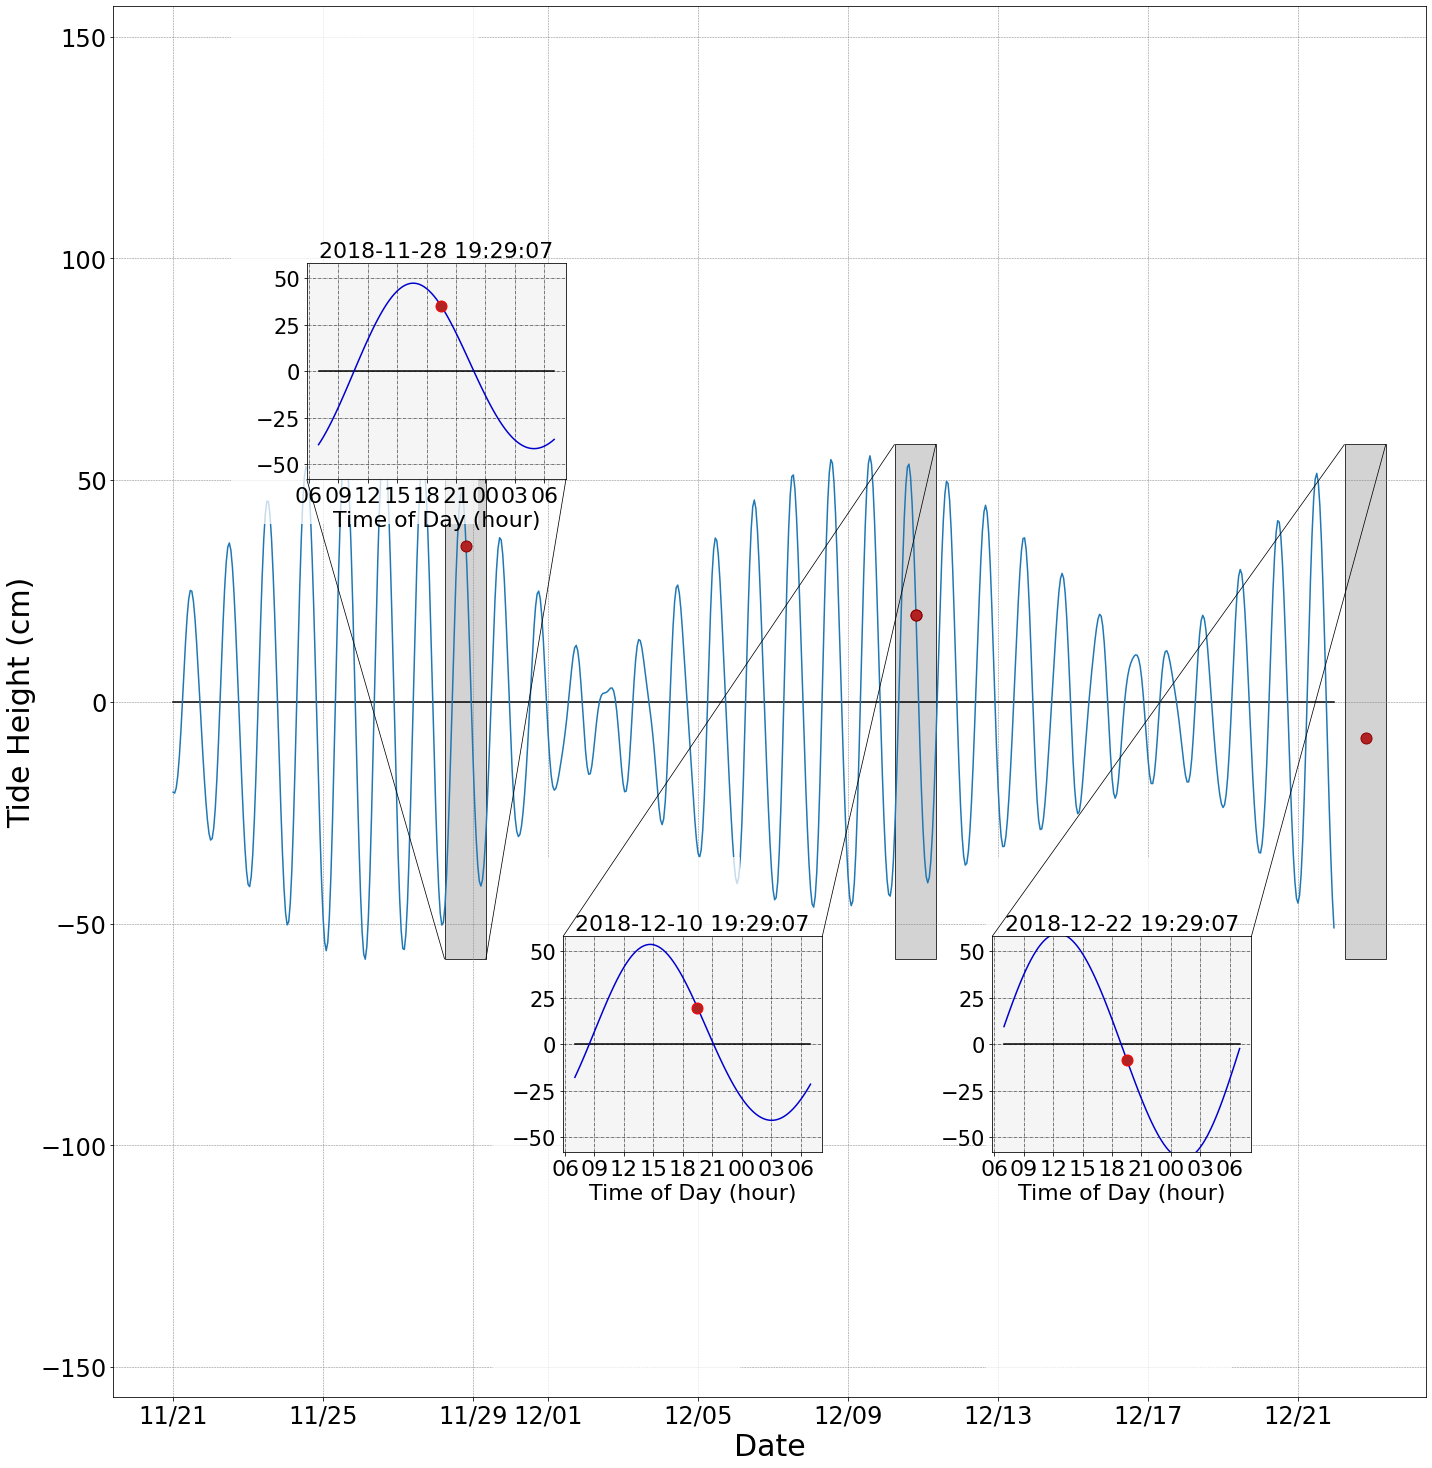

In [29]:
#   PLOT TIDE DATA

#--Load data
reference = df_tide.iloc[j]['Reference']

month = df_tide.iloc[j]['Tide Timeseries Month']
monthDates = df_tide.iloc[j]['Timestamp Series Month']

day1 = df_tide.iloc[j]['Datetime 1']
tide1 = df_tide.iloc[j]['Tide 1']
timeDay1 = df_tide.iloc[j]['Timestamp Series 1']
tidesDay1 = df_tide.iloc[j]['Tide Timeseries 1']

day2 = df_tide.iloc[j]['Datetime 2']
tide2 = df_tide.iloc[j]['Tide 2']
timeDay2 = df_tide.iloc[j]['Timestamp Series 2']
tidesDay2 = df_tide.iloc[j]['Tide Timeseries 2']

day3 = df_tide.iloc[j]['Datetime 3']
tide3 = df_tide.iloc[j]['Tide 3']
timeDay3 = df_tide.iloc[j]['Timestamp Series 3']
tidesDay3 = df_tide.iloc[j]['Tide Timeseries 3']

day4 = df_tide.iloc[j]['Datetime 4']
tide4 = df_tide.iloc[j]['Tide 4']
timeDay4 = df_tide.iloc[j]['Timestamp Series 4']
tidesDay4 = df_tide.iloc[j]['Tide Timeseries 4']

#-- Specify date & time format for plots
fmt_month = dates.DateFormatter('%m/%d')
fmt_day = dates.DateFormatter('%H')

#-- Axis limits
monthMax = np.max(month)
monthMin = np.min(month)

#****************************************************************************
#-- PLOT
#*********************
print('GL data file displayed: ',reference)

#-- Set condition for plotting day 3
diff = 0
for i in range(len(tidesDay2)):
    diff += tidesDay3[i]-tidesDay2[i]

#-- Define bottom left position for opaque boxes
tbound1 = dates.date2num(monthDates[37])
tbound2 = dates.date2num(monthDates[195])
width = tbound2 - tbound1
tbound3 = dates.date2num(monthDates[205])
tbound4 = dates.date2num(monthDates[365])
tbound5 = dates.date2num(monthDates[520])

#-- Main plot
fig, ax = plt.subplots(figsize=(20,20.5))

ax.plot(monthDates, np.zeros(len(monthDates)), color='black')
ax.plot(monthDates, month)
ax.xaxis.set_major_formatter(fmt_month)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Tide Height (cm)', fontsize=30)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_ylim(2.7*monthMin, 2.7*monthMax)
plt.grid(which='major', linestyle='--', linewidth='0.5', color='gray')
#-- Mark data aquisition on main plot
ax.plot([day1, day2, day3, day4], [tide1, tide2, tide3, tide4], marker='o', linestyle='None', markerfacecolor='firebrick', color='darkred', markersize=11)
#-- Add opaque box where inset plots will be placed
ax.add_artist(Rectangle((tbound1, 40), width, 150, facecolor=(1,1,1,0.75), zorder=2))
ax.add_artist(Rectangle((tbound3, -35), width, -150, facecolor=(1,1,1,0.75), zorder=2))
if diff != 0.0: 
    ax.add_artist(Rectangle((tbound4, 40), width, 150, facecolor=(1,1,1,0.75), zorder=2))
ax.add_artist(Rectangle((tbound5, -35), width, -150, facecolor=(1,1,1,0.75), zorder=2))
#-- Inset plots
#-- day 1
axins_1 = inset_axes(ax, 3.6,3.0, bbox_to_anchor=(.399, 0.822), bbox_transform=fig.transFigure)
axins_1.plot(timeDay1, np.zeros(len(timeDay1)), color='black')
axins_1.plot(timeDay1, tidesDay1, label=date1, color='mediumblue')
axins_1.set_facecolor('whitesmoke')
axins_1.plot(day1, tide1, marker='o', markerfacecolor='firebrick', color='red', markersize=11)
axins_1.set_title(day1, fontsize=22)
axins_1.set_ylim(monthMin, monthMax)
axins_1.xaxis.set_major_formatter(fmt_day)
axins_1.tick_params(axis='x', labelsize=22)
axins_1.tick_params(axis='y', labelsize=21)
axins_1.set_xlabel('Time of Day (hour)', fontsize=22)
mark_inset(ax, axins_1, loc1=3, loc2=4, facecolor='lightgray', edgecolor='black', linewidth=0.75)
plt.grid(True, color='black', linestyle='-.', linewidth='0.5')
#-- day 2
axins_2 = inset_axes(ax, 3.6,3.0, bbox_to_anchor=(.577, 0.366), bbox_transform=fig.transFigure)
axins_2.plot(timeDay2, np.zeros(len(timeDay2)), color='black')
axins_2.plot(timeDay2, tidesDay2, label=date2, color='mediumblue')
axins_2.set_facecolor('whitesmoke')
axins_2.plot(day2, tide2, marker='o', markerfacecolor='firebrick', color='red', markersize=11)
axins_2.set_title(day2, fontsize=22)
axins_2.set_ylim(monthMin, monthMax)
axins_2.xaxis.set_major_formatter(fmt_day)
axins_2.tick_params(axis='x', labelsize=22)
axins_2.tick_params(axis='y', labelsize=21)
axins_2.set_xlabel('Time of Day (hour)', fontsize=22)
mark_inset(ax, axins_2, loc1=1, loc2=2, facecolor='lightgray', edgecolor='black', linewidth=0.75)
plt.grid(True, color='black', linestyle='-.', linewidth='0.5')
#-- day 3
if diff != 0.0:    
    axins_3 = inset_axes(ax, 3.6,3.0, bbox_to_anchor=(.717, 0.822), bbox_transform=fig.transFigure)
    axins_3.plot(timeDay3, np.zeros(len(timeDay3)), color='black')
    axins_3.plot(timeDay3, tidesDay3, label=date3, color='mediumblue')
    axins_3.set_facecolor('whitesmoke')
    axins_3.plot(day3, tide3, marker='o',  markerfacecolor='firebrick', color='red', markersize=11)
    axins_3.set_title(day3, fontsize=22)
    axins_3.set_ylim(monthMin, monthMax)
    axins_3.xaxis.set_major_formatter(fmt_day)
    axins_3.tick_params(axis='x', labelsize=22)
    axins_3.tick_params(axis='y', labelsize=21)
    axins_3.set_xlabel('Time of Day (hour)', fontsize=22)
    mark_inset(ax, axins_3, loc1=3, loc2=4, facecolor='lightgray', edgecolor='black', linewidth=0.75)
    plt.grid(True, color='black', linestyle='-.', linewidth='0.5')
#-- day 4
axins_4 = inset_axes(ax, 3.6,3.0, bbox_to_anchor=(.875, 0.366), bbox_transform=fig.transFigure)
axins_4.plot(timeDay4, np.zeros(len(timeDay4)), color='black')
axins_4.plot(timeDay4, tidesDay4, label=date4, color='mediumblue')
axins_4.set_facecolor('whitesmoke')
axins_4.plot(day4, tide4, marker='o', markerfacecolor='firebrick', color='red', markersize=11)
axins_4.set_title(day4, fontsize=22)
axins_4.set_ylim(monthMin, monthMax)
axins_4.xaxis.set_major_formatter(fmt_day)
axins_4.tick_params(axis='x', labelsize=22)
axins_4.tick_params(axis='y', labelsize=21)
axins_4.set_xlabel('Time of Day (hour)', fontsize=22)
mark_inset(ax, axins_4, loc1=1, loc2=2, facecolor='lightgray', edgecolor='black', linewidth=0.75)
plt.grid(True, color='black', linestyle='-.', linewidth='0.5')

location = "Denman Glacier"

formatted_day1 = day1.strftime("%Y-%m-%d")
formatted_day2 = day2.strftime("%Y-%m-%d")
formatted_day3 = day3.strftime("%Y-%m-%d")
formatted_day4 = day4.strftime("%Y-%m-%d")

save_directory = "directory/NISAR Notebook Development Plan for Vertical Displacement/Output/"
filename = f"{formatted_day1}_{formatted_day2}_{formatted_day3}_{day4}_{location}_tides.pdf"
filename = filename.replace(":", "").replace(" ", "_")
full_path = f"{save_directory}/{filename}"
plt.tight_layout()
plt.savefig(full_path, format='pdf')
plt.show()

In [11]:
DifferentialTide = abs((tide1-tide2)-(tide3-tide4))
print(DifferentialTide)
tide_error = 5

75.79758838859074


In [22]:
#   READ GPS DATA

from datetime import datetime

def datetime_to_decimal_year(date):
    start_of_year = datetime(date.year, 1, 1)
    start_of_next_year = datetime(date.year + 1, 1, 1)
    year_length = (start_of_next_year - start_of_year).total_seconds()
    time_since_start_of_year = (date - start_of_year).total_seconds()
    return date.year + time_since_start_of_year / year_length

days_decimal = [datetime_to_decimal_year(day) for day in [day1, day2, day3, day4]]

# Load your data
import pandas as pd
file_path = 'GPSdata/wholeTimeSeriesLLH.noLoad.decYr.txt'
data = pd.read_csv(file_path, sep=" ", header=None)
data.columns = ["time", "latitude", "longitude", "height", "epoch", "station_name"]

avg_heights = []
closest_lat_lon = None

for idx, day in enumerate(days_decimal):
    data['time_diff'] = abs(data['time'] - day)
    nearest_ten = data.sort_values(by='time_diff').head(10)
    avg_height = nearest_ten['height'].mean()
    avg_heights.append(avg_height)
    
    if idx == 0:  # For day1
        closest_lat_lon = nearest_ten.iloc[0][['latitude', 'longitude']].values

DifferentialGPS = (avg_heights[0] - avg_heights[1]) - (avg_heights[2] - avg_heights[3])

from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")
latitude, longitude = closest_lat_lon
x, y = transformer.transform(latitude, longitude)

print("DifferentialGPS:", DifferentialGPS)

print("Latitude closest to day1:", closest_lat_lon[0])
print("Longitude closest to day1:", closest_lat_lon[1])

print("Converted Coordinates in EPSG:3031:")
print("X:", x, "Y:", y)

AttributeError: 'int' object has no attribute 'year'

In [23]:
# only for Denman Glacier
DifferentialGPS = DifferentialTide
GPS_error = 0

NameError: name 'DifferentialTide' is not defined

In [24]:
#   READ SAR DATA

import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from math import cos, pi
import math

# Set the folder path and point coordinates
folder_path = 'directory/NISAR Notebook Development Plan for Vertical Displacement/Unwrapped phase/'  # Replace with your folder path
shapefile_path = os.path.join(folder_path, 'Grounded_area.shp')  # Replace with your shapefile name
point_floating_ice = (2579689.4603, -380649.8925)  # Replace with actual coordinates in EPSG:3031

# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

# Function to calculate the average and standard deviation in the shapefile area
def calculate_avg_std(tif_path, shape):
    with rasterio.open(tif_path) as src:
        # Directly pass the shape if it is already a geometry object
        out_image, _ = mask(src, [shape], crop=True)
        # out_image is a numpy array, we can directly index it
        data = out_image[0]
        # Mask the nodata values
        valid_data = data[data != src.nodata]
        # Calculate and return mean and standard deviation, ignoring NaN values
        return np.nanmean(valid_data), np.nanstd(valid_data)

# Function to extract the value at a point from a tif file
def extract_point_value(tif_path, point):
    with rasterio.open(tif_path) as src:
        for val in src.sample([point]):
            return val[0]

# Find all .tif files in the folder
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]

# Calculate the average and standard deviation for the first .tif file
phaze_ref_avg, phaze_ref_std = calculate_avg_std(tif_files[0], shapefile.geometry[0])

# Convert angle from degrees to radians
angle_in_degrees = 40
angle_in_radians = math.radians(angle_in_degrees)

# Calculate the cosine of the angle
cosine_value = math.cos(angle_in_radians)

def extract_point_value(tif_path, point):
    with rasterio.open(tif_path) as src:
        for val in src.sample([point]):
            print(f"Value at {point}: {val[0]}")  # Debug print
            return val[0]

# Calculate delta_Z_SAR for each .tif file
delta_Z_SAR_values = []
for tif in tif_files:
    phase_floating_ice = extract_point_value(tif, point_floating_ice)
    delta_Z_SAR = abs(24.262 * (phase_floating_ice - phaze_ref_avg) / (4 * pi * cosine_value))
    delta_Z_SAR_values.append(delta_Z_SAR)
delta_Z_SAR_std = abs(24.262 * (phaze_ref_std) / (4 * pi * cosine_value))

    
# Results
print("Phaze Ref Avg:", phaze_ref_avg)
print("Phaze Ref Std:", phaze_ref_std)
print("Delta Z SAR Values:", delta_Z_SAR_values)
print("Delta Z SAR Std:", delta_Z_SAR_std)

ModuleNotFoundError: No module named 'rasterio'

In [18]:
#   SAVE TIDE/GPS/SAR DATA

import pandas as pd
import os

# Combine day1, day2, day3, and day4 into a time string
time = f"{day1}, {day2}, {day3}, {day4}"

# Create a DataFrame with the required format
data = pd.DataFrame({
    "Time": [time],
    "DifferentialTide": [DifferentialTide],
    "tide_error": [tide_error],
    "DifferentialGPS": [DifferentialGPS],
    "GPS_error": [GPS_error],
    "delta_Z_SAR_values": [delta_Z_SAR_values],
    "delta_Z_SAR_std": [delta_Z_SAR_std]
})

# Excel file name
file_name = "directory/NISAR Notebook Development Plan for Vertical Displacement/Output/Tide_GPS_SAR.xlsx"

# Check if the file exists
if os.path.exists(file_name):
    # Read existing data
    existing_data = pd.read_excel(file_name)
    # Append new data
    updated_data = existing_data.append(data, ignore_index=True)
else:
    updated_data = data

# Save to Excel
updated_data.to_excel(file_name, index=False)

print(f"Data successfully saved to {file_name}.")

Data successfully saved to C://Users/henni/Desktop/NISAR Notebook Development Plan for Vertical Displacement/Output/Tide_GPS_SAR.xlsx.


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


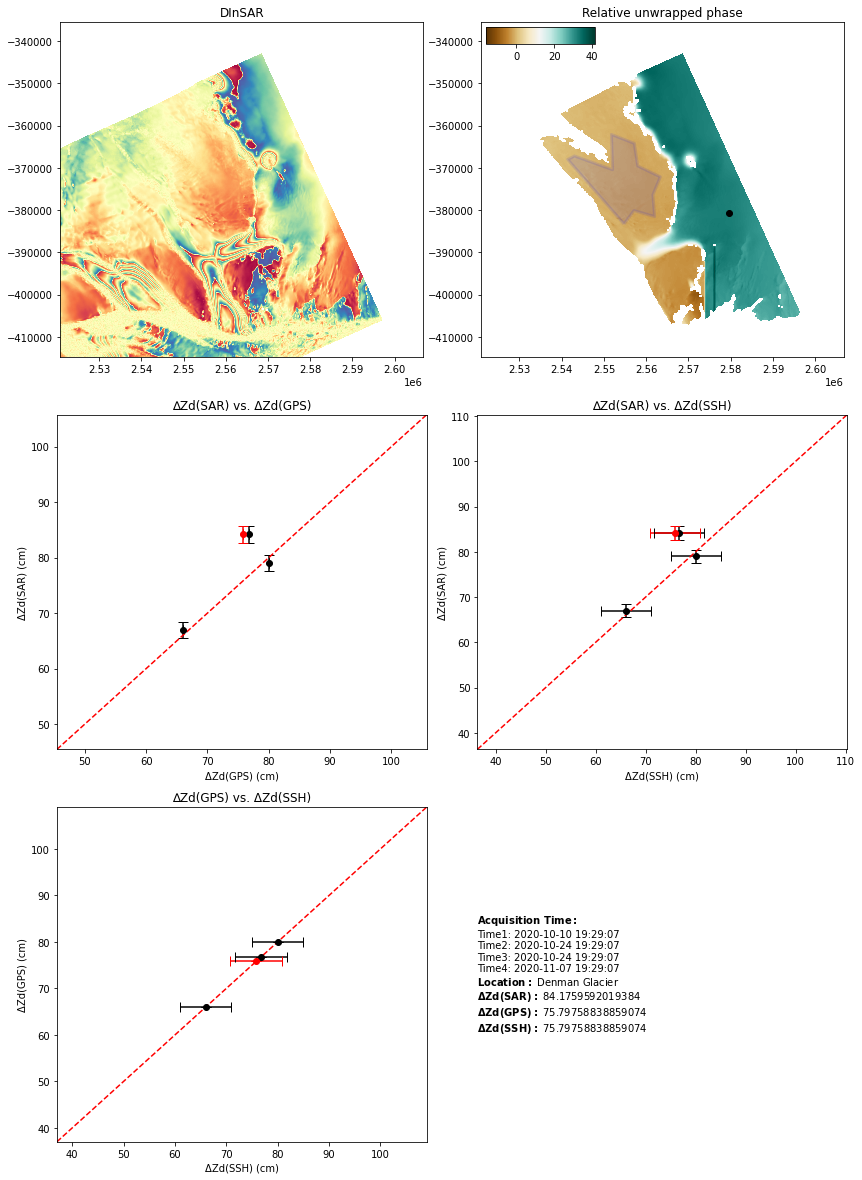

In [22]:
#   PLOT TIDE/GPS/SAR DATA

import rasterio
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import ast
from datetime import datetime
import geopandas as gpd
import matplotlib.patches as mpatches
from shapely.geometry import Point

# Function to plot TIFF files and data from Excel file
def plot_tiff_files(overlay_file1, overlay_file2, excel_file, shapefile_path, point_floating_ice):
    # Read data from the Excel file
    data = pd.read_excel(excel_file)
    # Get the last row values
    last_row = data.iloc[-1]

    # Extracting values from the last row
    time = last_row['Time']
    DifferentialTide = last_row['DifferentialTide']
    tide_error = last_row['tide_error']
    DifferentialGPS = last_row['DifferentialGPS']
    GPS_error = last_row['GPS_error']
    delta_Z_SAR_values = last_row['delta_Z_SAR_values']
    delta_Z_SAR_std = last_row['delta_Z_SAR_std']

    # Split the time string to get separate date-time components
    time_components = time.split(', ')
    if len(time_components) >= 4:
        day1 = datetime.strptime(time_components[0], "%Y-%m-%d %H:%M:%S")
        day2 = datetime.strptime(time_components[1], "%Y-%m-%d %H:%M:%S")
        day3 = datetime.strptime(time_components[2], "%Y-%m-%d %H:%M:%S")
        day4 = datetime.strptime(time_components[3], "%Y-%m-%d %H:%M:%S")
    else:
        raise ValueError("Not enough date-time components in the 'Time' column.")

    formatted_day1 = day1.strftime("%Y-%m-%d")
    formatted_day2 = day2.strftime("%Y-%m-%d")
    formatted_day3 = day3.strftime("%Y-%m-%d")
    formatted_day4 = day4.strftime("%Y-%m-%d")
    
    # Create figure and axes
    fig, ax = plt.subplots(3, 2, figsize=(12, 16.5))

    # Read the overlay TIFF files
    with rasterio.open(overlay_file1) as src_overlay1, rasterio.open(overlay_file2) as src_overlay2:
        overlay_data1 = src_overlay1.read(1)
        overlay_data2 = src_overlay2.read(1)
        
        # Mask 'no data' values and value 0
        overlay_data1_masked = ma.masked_where(overlay_data1 == 0, overlay_data1)
        overlay_data2_masked = ma.masked_where(overlay_data2 == src_overlay2.nodata, overlay_data2)
        
        # Determine extents for overlay data
        overlay_extent1 = (src_overlay1.bounds.left, src_overlay1.bounds.right, src_overlay1.bounds.bottom, src_overlay1.bounds.top)
        overlay_extent2 = (src_overlay2.bounds.left, src_overlay2.bounds.right, src_overlay2.bounds.bottom, src_overlay2.bounds.top)

        # Plot the overlay TIFF files
        ax[0, 0].imshow(overlay_data1_masked, cmap='Spectral', extent=overlay_extent1)
        im = ax[0, 1].imshow(overlay_data2_masked, cmap='BrBG', extent=overlay_extent2)

    # Load and plot shapefile
    shapefile = gpd.read_file(shapefile_path)
    shapefile.to_crs(src_overlay2.crs, inplace=True)
    shapefile.plot(ax=ax[0, 1], facecolor='blue', edgecolor='blue', alpha=0.1, linewidth=3)

    # Plot the point
    point_geom = Point(point_floating_ice)
    point_gdf = gpd.GeoDataFrame([1], geometry=[point_geom], crs=shapefile.crs)
    point_gdf.to_crs(src_overlay2.crs, inplace=True)
    point_gdf.plot(ax=ax[0, 1], color='black', marker='o')
    
    # Set titles
    ax[0, 0].set_title("DInSAR")
    ax[0, 1].set_title("Relative unwrapped phase")

    # Create an inset_axes instance in the upper left corner of the right plot
    cbaxes = inset_axes(ax[0, 1], width="30%", height="5%", loc='upper left') 
    plt.colorbar(im, cax=cbaxes, orientation='horizontal')
    cbaxes.xaxis.set_ticks_position("bottom")
    cbaxes.xaxis.set_label_position("top")
    
    max_value1, min_value1 = float('-inf'), float('inf')
    max_value2, min_value2 = float('-inf'), float('inf')
    max_value3, min_value3 = float('-inf'), float('inf')
    
    # Iterate through all rows in the dataset
    for i, row in data.iterrows():
        # Extract values
        delta_Z_SAR_values_list = ast.literal_eval(row['delta_Z_SAR_values'])
        delta_Z_SAR_values = [float(value) for value in delta_Z_SAR_values_list]
        delta_Z_SAR_std = float(row['delta_Z_SAR_std'])
        DifferentialGPS = float(row['DifferentialGPS'])
        GPS_error = float(row['GPS_error'])
        DifferentialTide = float(row['DifferentialTide'])
        tide_error = float(row['tide_error'])

        # Calculate max and min for ΔZd(SAR) vs. ΔZd(GPS)
        max_value1 = max(max_value1, max(delta_Z_SAR_values) + delta_Z_SAR_std, DifferentialGPS + GPS_error)
        min_value1 = min(min_value1, min(delta_Z_SAR_values) - delta_Z_SAR_std, DifferentialGPS - GPS_error)

        # Calculate max and min for ΔZd(SAR) vs. ΔZd(SSH)
        max_value2 = max(max_value2, max(delta_Z_SAR_values) + delta_Z_SAR_std, DifferentialTide + tide_error)
        min_value2 = min(min_value2, min(delta_Z_SAR_values) - delta_Z_SAR_std, DifferentialTide - tide_error)

        # Calculate max and min for ΔZd(GPS) vs. ΔZd(SSH)
        max_value3 = max(max_value3, DifferentialTide + tide_error, DifferentialGPS + GPS_error)
        min_value3 = min(min_value3, DifferentialTide - tide_error, DifferentialGPS - GPS_error)
    
    # SAR vs. GPS
    # Create scatter plot
    for i in range(len(data)):
        current_row = data.iloc[i]
        delta_Z_SAR_values_list = ast.literal_eval(current_row['delta_Z_SAR_values'])
        delta_Z_SAR_values = [float(value) for value in delta_Z_SAR_values_list]
        delta_Z_SAR_std = float(current_row['delta_Z_SAR_std'])
        DifferentialGPS = float(current_row['DifferentialGPS'])
        GPS_error = float(current_row['GPS_error'])
    
    # Highlight the last row in red
        color = 'red' if i == len(data) - 1 else 'black'
        ax[1, 0].errorbar([DifferentialGPS], delta_Z_SAR_values, 
                          yerr=delta_Z_SAR_std, xerr=GPS_error,
                          fmt='o', ecolor=color, color=color, capsize=5)
        
    # Calculate a buffer to keep the points away from the border
    buffer1 = (max_value1 - min_value1) * 1  # 100% of the range as buffer

    # Adjusted range for x and y axes
    adjusted_min1 = min_value1 - buffer1
    adjusted_max1 = max_value1 + buffer1

    ax[1, 0].plot([adjusted_min1, adjusted_max1], [adjusted_min1, adjusted_max1], 'r--')  # red dashed line
    ax[1, 0].set_xlim(adjusted_min1, adjusted_max1)
    ax[1, 0].set_ylim(adjusted_min1, adjusted_max1)
    ax[1, 0].set_xlabel('ΔZd(GPS) (cm)')
    ax[1, 0].set_ylabel('ΔZd(SAR) (cm)')
    ax[1, 0].set_title('∆Zd(SAR) vs. ΔZd(GPS)')
    
    # SAR vs. TIDE MODEL
    # Create scatter plot
    for i in range(len(data)):
        current_row = data.iloc[i]
        delta_Z_SAR_values_list = ast.literal_eval(current_row['delta_Z_SAR_values'])
        delta_Z_SAR_values = [float(value) for value in delta_Z_SAR_values_list]
        delta_Z_SAR_std = float(current_row['delta_Z_SAR_std'])
        DifferentialTide = float(current_row['DifferentialTide'])
        tide_error = float(current_row['tide_error'])
    
    # Highlight the last row in red
        color = 'red' if i == len(data) - 1 else 'black'
        ax[1, 1].errorbar([DifferentialTide], delta_Z_SAR_values, 
                          yerr=delta_Z_SAR_std, xerr=tide_error,
                          fmt='o', ecolor=color, color=color, capsize=5)

    # Calculate a buffer to keep the points away from the border
    buffer2 = (max_value2 - min_value2) * 1  # 100% of the range as buffer

    # Adjusted range for x and y axes
    adjusted_min2 = min_value2 - buffer2
    adjusted_max2 = max_value2 + buffer2

    ax[1, 1].plot([adjusted_min2, adjusted_max2], [adjusted_min2, adjusted_max2], 'r--')  # red dashed line
    ax[1, 1].set_xlim(adjusted_min2, adjusted_max2)
    ax[1, 1].set_ylim(adjusted_min2, adjusted_max2)
    ax[1, 1].set_xlabel('ΔZd(SSH) (cm)')
    ax[1, 1].set_ylabel('ΔZd(SAR) (cm)')
    ax[1, 1].set_title('∆Zd(SAR) vs. ΔZd(SSH)')
    
    # TIDE MODEL vs. GPS
    # Calculate a buffer to keep the points away from the border
    buffer3 = (max_value3 - min_value3) * 1  # 100% of the range as buffer

    # Adjusted range for x and y axes
    adjusted_min3 = min_value3 - buffer3
    adjusted_max3 = max_value3 + buffer3

    # Create scatter plot
    for i in range(len(data)):
        current_row = data.iloc[i]
        DifferentialGPS = float(current_row['DifferentialGPS'])
        GPS_error = float(current_row['GPS_error'])
        DifferentialTide = float(current_row['DifferentialTide'])
        tide_error = float(current_row['tide_error'])
    
    # Highlight the last row in red
        color = 'red' if i == len(data) - 1 else 'black'
        ax[2, 0].errorbar([DifferentialTide], [DifferentialGPS], 
                          yerr=GPS_error, xerr=tide_error,
                          fmt='o', ecolor=color, color=color, capsize=5)
    
    ax[2, 0].plot([adjusted_min3, adjusted_max3], [adjusted_min3, adjusted_max3], 'r--')  # red dashed line
    ax[2, 0].set_xlim(adjusted_min3, adjusted_max3)
    ax[2, 0].set_ylim(adjusted_min3, adjusted_max3)
    ax[2, 0].set_xlabel('ΔZd(SSH) (cm)')
    ax[2, 0].set_ylabel('ΔZd(GPS) (cm)')
    ax[2, 0].set_title('∆Zd(GPS) vs. ΔZd(SSH)')
    
    # Display information
    location = "Denman Glacier"
    delta_Z_SAR_values_str = ', '.join(map(str, delta_Z_SAR_values))  # Convert list to string
    info_text = (
        r"$\bf{Acquisition\ Time:}$" + "\n"
        f"Time1: {day1}\n"
        f"Time2: {day2}\n"
        f"Time3: {day3}\n"
        f"Time4: {day4}\n"
        r"$\bf{Location:}$" + f" {location}\n"
        r"$\bf{\Delta Zd(SAR):}$" + f" {delta_Z_SAR_values_str}\n"  # Use the converted string
        r"$\bf{\Delta Zd(GPS):}$" + f" {DifferentialGPS}\n"
        r"$\bf{\Delta Zd(SSH):}$" + f" {DifferentialTide}")

    ax[2, 1].text(0, 0.5, info_text, transform=ax[2, 1].transAxes, ha='left', va='center', fontsize=10)
    ax[2, 1].axis('off')
    
    # Save and show the plot
    save_directory = "directory/NISAR Notebook Development Plan for Vertical Displacement/Output/"
    filename = f"{formatted_day1}_{formatted_day2}_{formatted_day3}_{day4}_{location}.pdf"
    filename = filename.replace(":", "").replace(" ", "_")
    full_path = f"{save_directory}/{filename}"
    plt.tight_layout()
    plt.savefig(full_path, format='pdf')
    plt.show()

plot_tiff_files('directory/NISAR Notebook Development Plan for Vertical Displacement/Double-difference interferogram/gl_157_201010_201024_201024_201107_34475-34682-34682-34889_T192907_T192907.tif', 'directory/NISAR Notebook Development Plan for Vertical Displacement/Unwrapped phase/gl_157_201010_201024_201024_201107_34475-34682-34682-34889_T192907_T192907_unwrapped.tif', 'directory/NISAR Notebook Development Plan for Vertical Displacement/Output/Tide_GPS_SAR.xlsx', 'directory/NISAR Notebook Development Plan for Vertical Displacement/Unwrapped phase/Grounded_area.shp', point_floating_ice)